# Sentiment Analysis with Canadian Elections Data
## Author: Yonghao Li

In [ ]:
# !pip install tweet-preprocessor

# For timing each cell
!pip install ipython-autotime
%load_ext autotime

# !pip install prettytable

The autotime extension is already loaded. To reload it, use:
  %reload_ext autotime
time: 2.53 s (started: 2021-03-21 19:46:27 +00:00)


In [ ]:
# Load necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load word processing libraries
import re
import unicodedata
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
from nltk.tokenize import word_tokenize
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')
from wordcloud import WordCloud

# Load ML libraries
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, KFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, roc_curve, auc, roc_auc_score, confusion_matrix, classification_report, precision_score, recall_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from xgboost.sklearn import XGBClassifier

import warnings
warnings.filterwarnings("ignore")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
time: 2.8 s (started: 2021-03-21 19:46:29 +00:00)


## Load Data

In [ ]:
# Load sentiment analysis data
sentiment_df = pd.read_csv('sentiment_analysis.csv')
pd.set_option('display.max_colwidth', None)
sentiment_df.head()

,ID,text,label
0,7.680980e+17,Josh Jenkins is looking forward to TAB Breeders Crown Super Sunday https://t.co/antImqAo4Y https://t.co/ejnA78Sks0,1
1,7.680980e+17,RT @MianUsmanJaved: Congratulations Pakistan on becoming #No1TestTeam in the world against all odds! #JI_PakZindabadRallies https://t.co/1o…,1
2,7.680980e+17,"RT @PEPalerts: This September, @YESmag is taking you to Maine Mendoza’s surprise thanksgiving party she threw for her fans! https://t.co/oX…",1
3,7.680980e+17,"RT @david_gaibis: Newly painted walls, thanks a million to our custodial painters this summer. Great job ladies!!!#EC_proud https://t.co/…",1
4,7.680980e+17,RT @CedricFeschotte: Excited to announce: as of July 2017 Feschotte lab will be relocating to @Cornell MBG https://t.co/dd0FG7BRx3,1


time: 1.13 s (started: 2021-03-21 19:46:32 +00:00)


In [ ]:
# Load Canadian election data
Canadian_elections_df = pd.read_csv('Canadian_elections_2019.csv')
pd.set_option('display.max_colwidth', None)
Canadian_elections_df.head()

,sentiment,negative_reason,text
0,negative,Women Reproductive right and Racism,"b""@RosieBarton So instead of your suggestion, how about we agree that #Canadian #women can not and should not trust that #AndrewScheer and a #Conservatives government will protect a woman's right to have automony over her body. Let's go with that. #cdnpoli #elxn43 #Canada #abortion"""
1,positive,NaN,"b""#AllWomanSpacewalk it's real!\n@Space_Station \n#EtobicokeNorth #CityofTO #ONPoli #cdnpoli #elxn43 https://t.co/wgdXLksTbQ"""
2,negative,Economy,"b""#Brantford It's going to cost YOU $94 BILLION FOR THE NEXT 4 YEARS! ASK JUSTIN! #elxn43 #cdnpoli #Canada https://t.co/9DTLLd9972"""
3,positive,NaN,"b""#Canada #CanadaElection2019 #CanadaVotes \n#elxn43 \n\nCan't decide? This should help!\n\nhttps://t.co/UNe5J1tDJ6"""
4,negative,Economy,"b""#Canada #taxpayers are sick &amp; tired of having their hard earned $ donated to corporate welfare bums that don't need it! This is only one of many reasons #TrudeauMustGo. @SNCLavalin can leave #Canada for all I care. @Sheila_Copps #SNCLavalinScandal #Election2019 #elxn43 #cdnpoli https://t.co/ywD7MAByKk"""


time: 27.4 ms (started: 2021-03-21 19:46:33 +00:00)


In [ ]:
sentiment_df.shape

(550391, 3)

time: 3.17 ms (started: 2021-03-21 19:46:33 +00:00)


In [ ]:
Canadian_elections_df.shape

(2133, 3)

time: 2.65 ms (started: 2021-03-21 19:46:33 +00:00)


## Data Cleaning

Cleaning the tweets text data include the following:
- Remove HTML tags and attributes;
- Replace HTML character codes with ASCII equivalents;
- Remove URLs and mentions;
- Remove new-line characters, other non-letters, and extra white spaces;
- Remove the retweet characters ('RT');
- Lemmatization of remaining words;
- Remove stopwords and words with only two letters.

Using NLTK stopwords, which include pronouns (such as 'i', 'we', 'she') and other transitional words (such as 'the', 'and', 'if'), we can remove words with little meaning from the tweets. This can help us save space and extract meaningful words from each tweet before further analysis.

In [ ]:
# Using NLTK's list of stopwords
stopword_list = stopwords.words('english')
stopword_list.append('snail')
print(stopword_list)

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

In [ ]:
lemmatizer = WordNetLemmatizer()

# Create function for cleaning the tweets column
def clean_text(s):
    # Make sure all characters are in lowercase
    s = s.lower()

    # Remove HTML tags and attributes from the string
    # s = BeautifulSoup(s,'lxml').get_text() # takes longer
    html_tags = re.compile('<.*?>')
    s = re.sub(html_tags, '', s)

    # Replace HTML character codes with ASCII equivalent
    s = unicodedata.normalize('NFKD', s).encode('ascii', 'ignore').decode('utf-8')

    # Remove URLs, emojis, mentions, smiley faces, and numbers
    # p.set_options(p.OPT.URL, p.OPT.EMOJI, p.OPT.MENTION, p.OPT.SMILEY, p.OPT.NUMBER)
    # s = p.clean(s) # takes too long

    # Remove URLs
    s = re.sub(r'http\S+', '', s)

    # Remove mentions
    s = re.sub("@[A-Za-z0-9]+", "", s)

    # Remove new line and line breaks characters
    s = s.replace('b"', '').replace("b'", '').replace('\n', '').replace('\\n', '').replace('\\n\\n', '').replace('\t', '')

    # Replace non-letters and extra white spaces with one space
    non_letters = re.compile('[^a-zA-Z]+')
    s = non_letters.sub(' ', s)
    
    # Remove retweet letters
    s = re.sub(r'\brt\b', '', s)

    # Lemmatization
    s = lemmatizer.lemmatize(s)

    # Remove stop words
    text_tokens = word_tokenize(s)
    s = [word for word in text_tokens if not word in stopword_list]

    # Remove words with only 2 letters
    s = [i for i in s if len(i) > 2]

    if not s:
        return []
    return s

time: 42.1 ms (started: 2021-03-21 19:46:33 +00:00)


In [ ]:
# Apply the cleaning procedure to the sentiment data (takes a while)
sentiment_df.text = sentiment_df.text.apply(clean_text)
sentiment_df.drop(['ID'], axis=1, inplace=True)
pd.set_option('display.max_colwidth', None)
sentiment_df.head(8)

,text,label
0,"[josh, jenkins, looking, forward, tab, breeders, crown, super, sunday]",1
1,"[congratulations, pakistan, becoming, testteam, world, odds, pakzindabadrallies]",1
2,"[september, taking, maine, mendozas, surprise, thanksgiving, party, threw, fans]",1
3,"[gaibis, newly, painted, walls, thanks, million, custodial, painters, summer, great, job, ladies, proud]",1
4,"[excited, announce, july, feschotte, lab, relocating, mbg]",1
5,"[excited, illuminate]",1
6,"[firstdayofschool, students, amp, teachers, good, luck, successful, school, year, educationmatters]",1
7,"[srk, kajol, making, ddlj, song, greatest, ever]",1


time: 1min 27s (started: 2021-03-21 19:46:33 +00:00)


In [ ]:
# Apply the cleaning procedure to the Canadian elections data
Canadian_elections_df.text = Canadian_elections_df.text.apply(clean_text)
pd.set_option('display.max_colwidth', None)
Canadian_elections_df.head(8)

,sentiment,negative_reason,text
0,negative,Women Reproductive right and Racism,"[instead, suggestion, agree, canadian, women, trust, andrewscheer, conservatives, government, protect, woman, right, automony, body, let, cdnpoli, elxn, canada, abortion]"
1,positive,NaN,"[allwomanspacewalk, real, station, etobicokenorth, cityofto, onpoli, cdnpoli, elxn]"
2,negative,Economy,"[brantford, going, cost, billion, next, years, ask, justin, elxn, cdnpoli, canada]"
3,positive,NaN,"[canada, canadaelection, canadavotes, elxn, decide, help]"
4,negative,Economy,"[canada, taxpayers, sick, amp, tired, hard, earned, donated, corporate, welfare, bums, need, one, many, reasons, trudeaumustgo, leave, canada, care, copps, snclavalinscandal, election, elxn, cdnpoli]"
5,negative,Others,"[canadavotes, elxn, cdnpoli, facts, blastfromthepast, conservatives, introduced, end, long, gun, registry, even, though, heads, police, across, canada, victims, groups, objected, crime, control, public, safety, gunlobby]"
6,positive,NaN,"[cdnmedia, elxn, cdnpoli, ppc, rocky, dong, hands, best, election, video, ever, please, google, rocky, dong, boxes, socialism, seen, rocky]"
7,positive,NaN,"[cdnpoli, elxn, liberals, double, promised, national, debt, next, term, elected, forecasting, billion, national, pharmacare, program, incl, ndp, coalition, billion, seems, possible, imo]"


time: 609 ms (started: 2021-03-21 19:48:01 +00:00)


## EDA

### Determine Party Affiliations of Tweets in the Canadian Elections Dataset

By first creating lists of keywords directly associated with each political party then comparing words in each tweet to these lists, we can get a sense of which party a particular tweet is associated with. With this method, we can approximate the political affiliations of the election tweets.

In [ ]:
# Create keyword lists for each party
liberal_kw = ['realchange', 'justin', 'trudeau', 'liberal', 'justintrudeau', 'lpc',
              'teamtrudeau', 'liberalparty', 'liberals', 'forward', 'chooseforward', 'lib']
conservative_kw = ['cpc', 'conservative', 'conservativeparty', 'andrew', 'scheer',
                   'andrewscheer', 'andrew scheer', 'conservatives', 'getahead', 'cons']
ndp_kw = ['ndp', 'new democratic party', 'democratic', 'newdemocratic', 'initforyou',
          'jagmeet', 'singh', 'jagmeetsingh', 'jagmeet singh']

# Create function for identifying Party affiliation
def party_identifier(tweet):
    # first create dictionary for each category (value for 'Others' initialized to 0.5 as a default)
    party_dict = {'Liberal': 0, 'Conservative': 0, 'NDP': 0, 'Others': 0.5}

    # check for keywords within each tweet words list
    for word in tweet:
        if word in liberal_kw:
            party_dict['Liberal'] += 1
        if word in conservative_kw:
            party_dict['Conservative'] += 1
        if word in ndp_kw:
            party_dict['NDP'] += 1

    import operator

    return max(party_dict.items(), key=operator.itemgetter(1))[0]

time: 14.9 ms (started: 2021-03-21 19:48:02 +00:00)


In [ ]:
# Apply the party identifier function
Canadian_elections_df['Party'] = Canadian_elections_df.text.apply(party_identifier)

# Show frequencies of each category
Canadian_elections_df.Party.value_counts()

Others          1206
Liberal          446
Conservative     384
NDP               97
Name: Party, dtype: int64

time: 33.1 ms (started: 2021-03-21 19:48:02 +00:00)


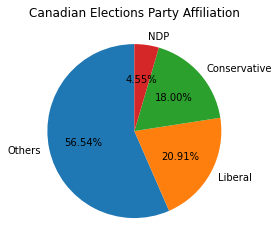

time: 112 ms (started: 2021-03-19 18:03:06 +00:00)


In [ ]:
# Show pie chart of estimated party affiliation percentages
party_labels = ['Others', 'Liberal', 'Conservative', 'NDP']
plt.pie(Canadian_elections_df.Party.value_counts(), labels=party_labels,
        autopct='%1.2f%%', startangle=90)
plt.title('Canadian Elections Party Affiliation')
plt.show()

Using the procedure above, the pie chart generated can approximate the percentage of tweets directly linked to each party. Out of the three parties, 20.91% of tweets are associated with Liberal, 18% of tweets are associated with Conservative, and only 4.55% are associated with NDP.

However, the party affiliation of around 56.54% of tweets could not be determined due to the following reasons:
- The keyword lists might not be comprehensive enough and might have missed some important keywords;
- The procedure of simply counting the number of particular keywords in a tweet might not be sufficient for determining party affiliation;
- Some tweets might be mutual such that keywords from multiple parties can appear in these tweets;
- Some tweets could have implied meaning and party affiliation that might not be detectable without the original context.

Looking at this result alone, the Liberal party seems to have more gotten attention from the voting population.

#### Bonus Plot (Party Affiliations)

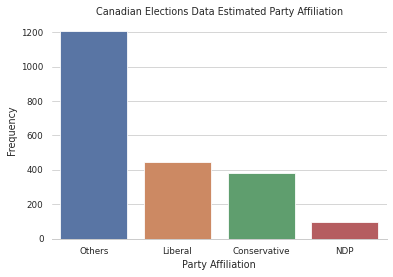

time: 236 ms (started: 2021-03-19 18:03:06 +00:00)


In [ ]:
# Visualize the frequency of each party affiliation in the Canadian elections data
sns.set_theme(style="whitegrid")
sns.set_context("paper")
values = Canadian_elections_df.Party.value_counts()
ax = sns.barplot(party_labels, values)
ax.set(xlabel='Party Affiliation', ylabel='Frequency', title='Canadian Elections Data Estimated Party Affiliation')
sns.despine(left=True)

#### Bonus Plot (Negative Reasons)

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 <a list of 10 Text major ticklabel objects>)

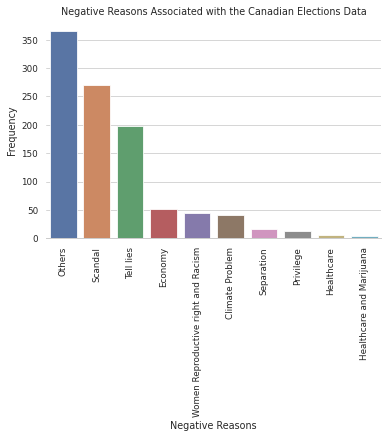

time: 383 ms (started: 2021-03-19 18:03:06 +00:00)


In [ ]:
# Visualize the frequencies of different negative reasons
sns.set_theme(style="whitegrid")
sns.set_context("paper")
index = Canadian_elections_df.negative_reason.value_counts().index
values = Canadian_elections_df.negative_reason.value_counts()
ax = sns.barplot(index, values)
ax.set(xlabel='Negative Reasons', ylabel='Frequency', title='Negative Reasons Associated with the Canadian Elections Data')
sns.despine(left=True)
plt.xticks(rotation='vertical')

#### Bonus WordCloud for Election Data

In [ ]:
# Set up words for word cloud
Canadian_elections_df.text = Canadian_elections_df.text.apply(' '.join)

positive_tweets = Canadian_elections_df[Canadian_elections_df.sentiment == 'positive'].text
negative_tweets = Canadian_elections_df[Canadian_elections_df.sentiment == 'negative'].text

positive_words = ' '.join(tw for tw in positive_tweets)
negative_words = ' '.join(tw for tw in negative_tweets)

time: 12.9 ms (started: 2021-03-21 19:48:02 +00:00)


Text(0.5, 1.0, 'Positive Sentiment WordCloud')

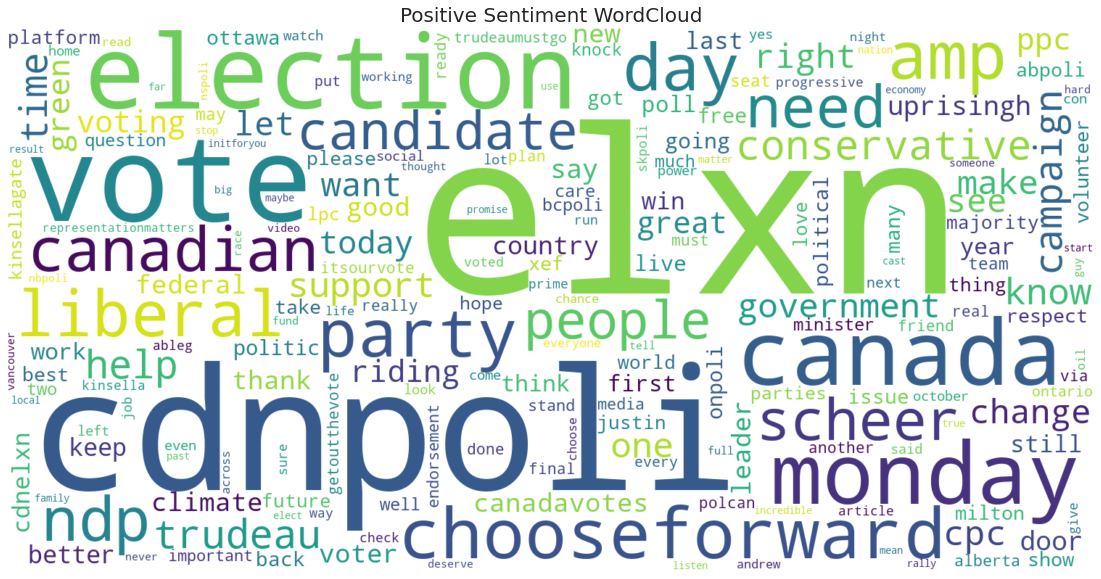

time: 2.94 s (started: 2021-03-19 18:03:07 +00:00)


In [ ]:
# Positive word cloud for the election data
wordcloud_positive = WordCloud(width=1500, height=750, max_words=200, 
                               background_color='white', collocations=False).generate(positive_words)
plt.figure(figsize=(20, 10))
plt.imshow(wordcloud_positive, interpolation='bilinear')
plt.axis('off')
plt.title('Positive Sentiment WordCloud', fontsize=20)

Text(0.5, 1.0, 'Negative Sentiment WordCloud')

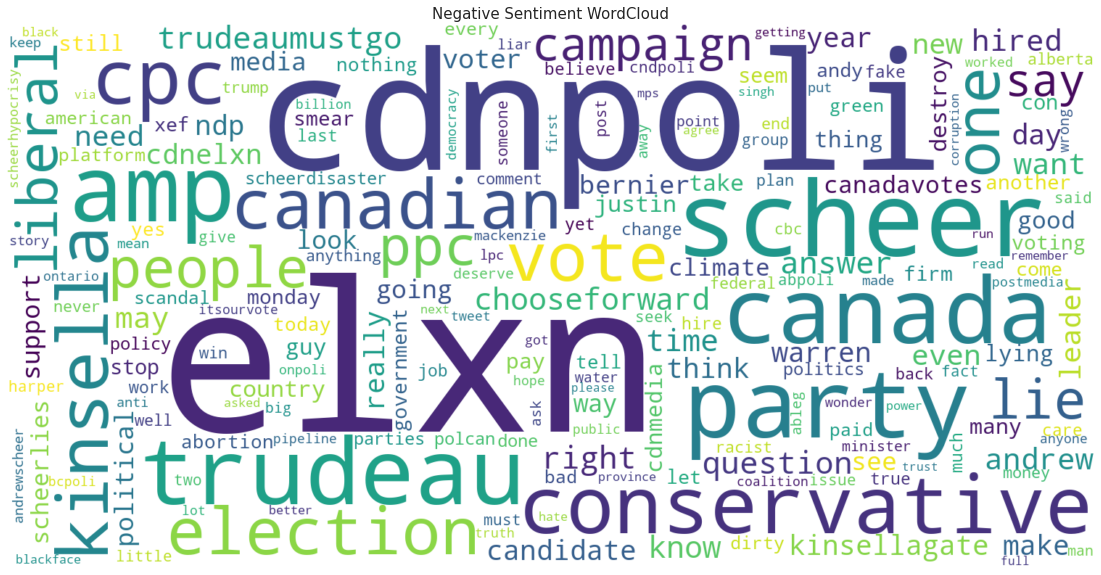

time: 3.1 s (started: 2021-03-19 18:03:10 +00:00)


In [ ]:
# Negative word cloud for the election data
wordcloud_negative = WordCloud(width=1500, height=750, max_words=200, 
                               background_color='white', collocations=False).generate(negative_words)
plt.figure(figsize=(20,10))
plt.imshow(wordcloud_negative, interpolation='bilinear')
plt.axis('off')
plt.title('Negative Sentiment WordCloud', fontsize=15)

### Visualizations of Sentiment Analysis Data

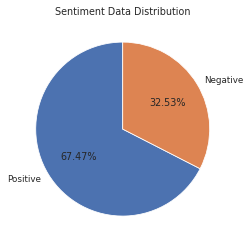

time: 112 ms (started: 2021-03-19 18:03:13 +00:00)


In [ ]:
# Show pie chart of sentiment percentages
sentiment_labels = ['Positive', 'Negative']
plt.pie(sentiment_df.label.value_counts(), labels=sentiment_labels,
        autopct='%1.2f%%', startangle=90)
plt.title('Sentiment Data Distribution')
plt.show()

In [ ]:
# Set up words for word cloud
sentiment_df.text = sentiment_df.text.apply(' '.join)

positive_tweets2 = sentiment_df[sentiment_df.label == 1].text
negative_tweets2 = sentiment_df[sentiment_df.label == 0].text

positive_words2 = ' '.join(tw for tw in positive_tweets2)
negative_words2 = ' '.join(tw for tw in negative_tweets2)

time: 453 ms (started: 2021-03-21 19:48:02 +00:00)


Text(0.5, 1.0, 'Positive Sentiment WordCloud')

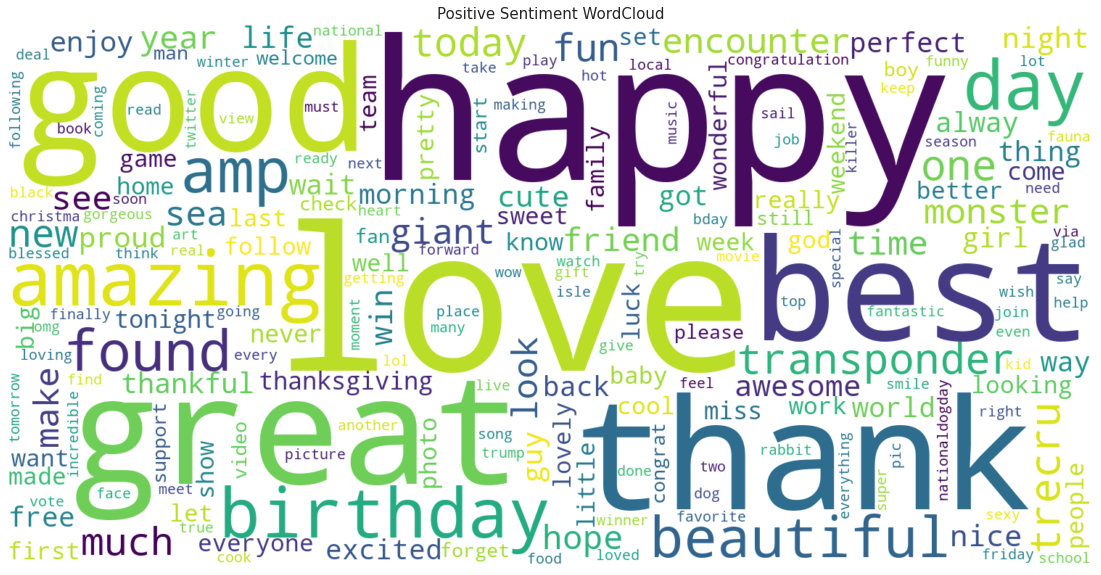

time: 7.16 s (started: 2021-03-19 18:03:14 +00:00)


In [ ]:
# Positive word cloud for the sentiment data
wordcloud_positive2 = WordCloud(width=1500, height=750, max_words=200, 
                                background_color='white', collocations=False).generate(positive_words2)
plt.figure(figsize=(20, 10))
plt.imshow(wordcloud_positive2, interpolation='bilinear')
plt.axis('off')
plt.title('Positive Sentiment WordCloud', fontsize=15)

The positive sentiment wordcloud generated from the sentiment analysis data is clearly populated with words with positive meaning, such as 'love', 'happy', 'good', and 'great'.

Text(0.5, 1.0, 'Negative Sentiment WordCloud')

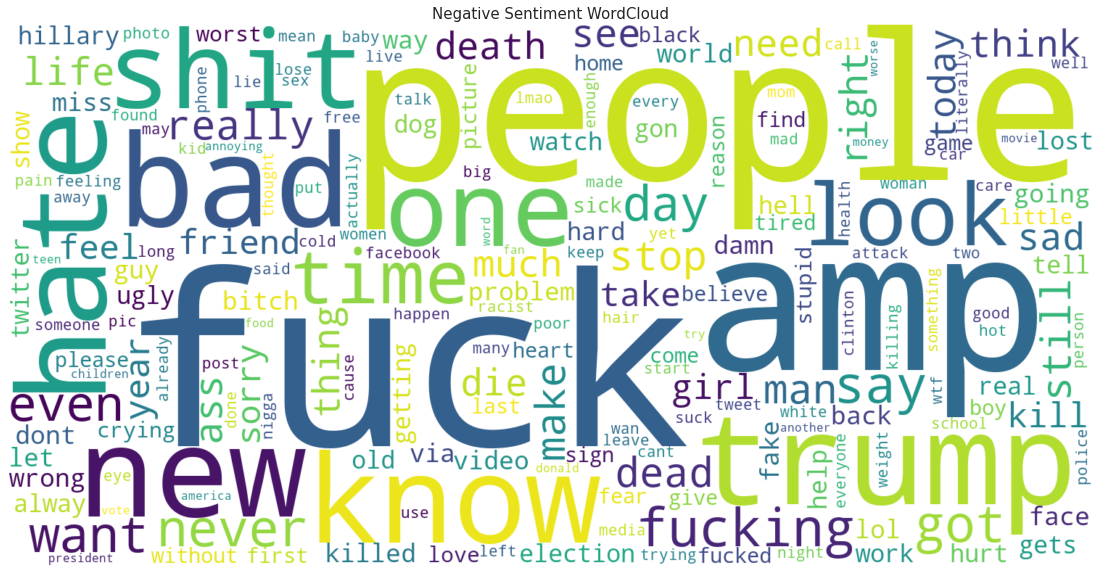

time: 5.35 s (started: 2021-03-19 18:03:21 +00:00)


In [ ]:
# Negative word cloud for the sentiment data
wordcloud_negative2 = WordCloud(width=1500, height=750, max_words=200, 
                                background_color='white', collocations=False).generate(negative_words2)
plt.figure(figsize=(20,10))
plt.imshow(wordcloud_negative2, interpolation='bilinear')
plt.axis('off')
plt.title('Negative Sentiment WordCloud', fontsize=15)

Contrary, the negative wordcloud is filled with negative words.

## Model Preparation

Since the output feature length is 159809 without the use of max_feature, this parameter is set to 1200 (at least 1000) in the vectorizers for faster model training.

In [ ]:
# Split sentiment data into training (70%) and testing (30%) sets
sentiment_copy = sentiment_df.copy(deep=True)
X = sentiment_copy.text
y = sentiment_copy.label
y = np.array(y).reshape(-1,1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)

time: 134 ms (started: 2021-03-21 19:48:02 +00:00)


### Bag of Words (WF)

In [ ]:
# Use CountVectorizer for bag-of-words approach
bow = CountVectorizer(max_features=1200, analyzer='word', token_pattern=r'\w+',
                      stop_words='english', ngram_range=(1, 1))
X_train_bow = bow.fit_transform(X_train)
X_test_bow = bow.transform(X_test)

time: 5.22 s (started: 2021-03-21 19:48:02 +00:00)


### TF-IDF

In [ ]:
# Use TfidfVectorizer for TF-IDF approach
tfidf = TfidfVectorizer(max_features=1200, analyzer='word', token_pattern=r'\w+',
                        stop_words='english', ngram_range=(1, 1))
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

time: 5.23 s (started: 2021-03-21 19:48:08 +00:00)


In [ ]:
# Check shapes
print(X_train_bow.shape)
print(X_test_bow.shape)
print(X_train_tfidf.shape)
print(X_test_tfidf.shape)
print(y_train.shape)
print(y_test.shape)

(385273, 1200)
(165118, 1200)
(385273, 1200)
(165118, 1200)
(385273, 1)
(165118, 1)
time: 7.3 ms (started: 2021-03-20 04:02:52 +00:00)


### Bonus Word Embeddings

For word embedding, we can use the Word2Vec library. Using word embedding can help retain some aspects of the original context. Word2Vec generates relatively small embedding vector in which each dimension represents an informational aspect of the word.

In [ ]:
import gensim
from gensim.models import Word2Vec

# Tokenize words in each row
X_train_we = X_train.apply(word_tokenize)
X_test_we = X_test.apply(word_tokenize)

# Implement Word2Vec
X_train_we = Word2Vec(X_train_we)
X_test_we = Word2Vec(X_test_we)

time: 1min 38s (started: 2021-03-19 18:03:37 +00:00)


In [ ]:
# Check the vocabulary dictionary generated by Word2Vec
X_train_we.wv.vocab

{'watching': <gensim.models.keyedvectors.Vocab at 0x7f22418ec850>,
 'tear': <gensim.models.keyedvectors.Vocab at 0x7f22418ec890>,
 'apart': <gensim.models.keyedvectors.Vocab at 0x7f22418ec8d0>,
 'eat': <gensim.models.keyedvectors.Vocab at 0x7f22418ec910>,
 'absolutely': <gensim.models.keyedvectors.Vocab at 0x7f22418ec990>,
 'terrifying': <gensim.models.keyedvectors.Vocab at 0x7f22418eca10>,
 'watch': <gensim.models.keyedvectors.Vocab at 0x7f22418eca50>,
 'whip': <gensim.models.keyedvectors.Vocab at 0x7f22418eca90>,
 'good': <gensim.models.keyedvectors.Vocab at 0x7f22418ec950>,
 'stand': <gensim.models.keyedvectors.Vocab at 0x7f22418ec9d0>,
 'mixer': <gensim.models.keyedvectors.Vocab at 0x7f22418ecad0>,
 'black': <gensim.models.keyedvectors.Vocab at 0x7f22418ecb10>,
 'friday': <gensim.models.keyedvectors.Vocab at 0x7f22418ecb50>,
 'love': <gensim.models.keyedvectors.Vocab at 0x7f22418ecb90>,
 'girl': <gensim.models.keyedvectors.Vocab at 0x7f22418ecbd0>,
 'pension': <gensim.models.keyedv

time: 32 ms (started: 2021-03-19 18:05:16 +00:00)


In [ ]:
# List 5 most similar words to 'love' in X_train
X_train_we.most_similar('love')[:5]

[('adore', 0.626725435256958),
 ('motavatormonday', 0.5852625370025635),
 ('loves', 0.5705314874649048),
 ('sing', 0.5694454908370972),
 ('singing', 0.5563710331916809)]

time: 41.6 ms (started: 2021-03-19 18:05:16 +00:00)


In [ ]:
# List 5 most similar words to 'love' in X_test
X_test_we.most_similar('love')[:5]

[('arohaselcaday', 0.7555441856384277),
 ('bubu', 0.7435711622238159),
 ('luh', 0.7353308796882629),
 ('luv', 0.7305940389633179),
 ('fav', 0.7182718515396118)]

time: 26.3 ms (started: 2021-03-19 18:05:16 +00:00)


### Bonus N-grams

N-gram can be achieved by using either CountVectorizer or TfidfVectorizer, the difference is the range of the n_gram parameter. For example, setting the parameter to (2, 2) would give only bigram results because the range only consists of 2.

In [ ]:
# Can change range of n_gram
lower_n = 1 # unigram
upper_n = 2 # bigram

# Using WF with N-gram
ngram_bow = CountVectorizer(max_features=1200, analyzer='word', token_pattern=r'\w+',
                            stop_words='english', ngram_range=(lower_n, upper_n))
X_train_ngbow = ngram_bow.fit_transform(X_train)
X_test_ngbow = ngram_bow.transform(X_test)

# Using TF-IDF with N-gram
ngram_tfidf = TfidfVectorizer(max_features=5000, analyzer='word', token_pattern=r'\w+',
                              stop_words='english', ngram_range=(lower_n, upper_n))
X_train_ngtfidf = ngram_tfidf.fit_transform(X_train)
X_test_ngtfidf = ngram_tfidf.transform(X_test)

time: 28.3 s (started: 2021-03-19 18:05:16 +00:00)


## Model Implementation and Tuning

In this section, we will implement the Bag-of-words and TF-IDF methods, each with 7 different models: logistic regression, k-NN, Naive Bayes, SVM, decision trees, Random Forest, and XGBoost. By comparing the performance metrics and ROC curves of these models, we can find the best one for further hyperparameter tuning.

(Note: since predict_proba is not built into Liblinear, which implements the LinearSVC model, the LinearSVC models are not compatible with the ROC_plot function.)

### Bag-of-Words (WF) Train-Test Sets

In [ ]:
# Create function for plotting ROC curve
def roc_plot(model, model_name, X_test_set, y_test_set):
    probs = model.predict_proba(X_test_set)
    preds = probs[:, 1]
    fpr, tpr, threshold = roc_curve(y_test_set, preds)
    roc_auc = auc(fpr, tpr)
    plt.title('ROC Curve for ' + model_name)
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

time: 17.1 ms (started: 2021-03-21 19:48:30 +00:00)


In [ ]:
# Initialize list for results
bow_results = []

time: 1.41 ms (started: 2021-03-19 18:05:44 +00:00)


#### Logistic Regression

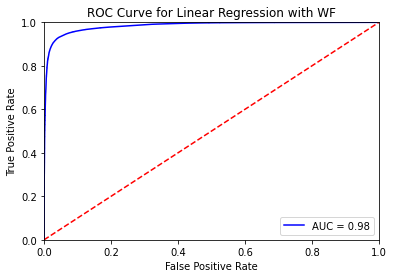

time: 6.03 s (started: 2021-03-20 21:51:25 +00:00)


In [ ]:
# Logistic regression model fitting and predictions
lr = LogisticRegression(penalty='l2', solver='newton-cg').fit(X_train_bow, y_train)
y_pred_train_lrbow = lr.predict(X_train_bow)
y_pred_test_lrbow = lr.predict(X_test_bow)

# Save results
bow_results.append({
        'classifier_name': 'Logistic Regression',
        'train accuracy': round(accuracy_score(y_train, y_pred_train_lrbow) * 100, 2),
        'test accuracy': round(accuracy_score(y_test, y_pred_test_lrbow) * 100, 2),
        'recall': round(recall_score(y_test, y_pred_test_lrbow), 2),
        'precision': round(precision_score(y_test, y_pred_test_lrbow), 2)
    })

# Plot ROC
roc_plot(lr, 'Linear Regression with WF', X_test_bow, y_test)

#### k-NN

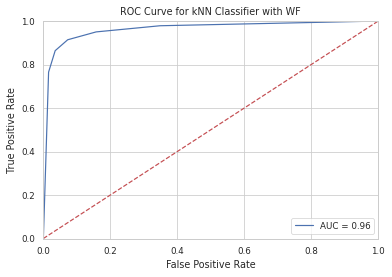

time: 1h 42min 45s (started: 2021-03-19 18:05:50 +00:00)


In [ ]:
# kNN model fitting and predictions
knn = KNeighborsClassifier(n_neighbors=5).fit(X_train_bow, y_train)
y_pred_train_knnbow = knn.predict(X_train_bow)
y_pred_test_knnbow = knn.predict(X_test_bow)

# Save results
bow_results.append({
        'classifier_name': 'kNN Classifier',
        'train accuracy': round(accuracy_score(y_train, y_pred_train_knnbow) * 100, 2),
        'test accuracy': round(accuracy_score(y_test, y_pred_test_knnbow) * 100, 2),
        'recall': round(recall_score(y_test, y_pred_test_knnbow), 2),
        'precision': round(precision_score(y_test, y_pred_test_knnbow), 2)
    })

# Plot ROC
roc_plot(knn, 'kNN Classifier with WF', X_test_bow, y_test)

#### Naive Bayes

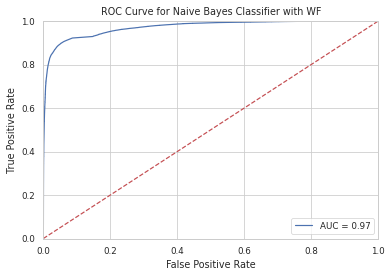

time: 638 ms (started: 2021-03-19 19:48:35 +00:00)


In [ ]:
# Naive bayes model fitting and predictions
nb = MultinomialNB().fit(X_train_bow, y_train)
y_pred_train_nbbow = nb.predict(X_train_bow)
y_pred_test_nbbow = nb.predict(X_test_bow)

# Save results
bow_results.append({
        'classifier_name': 'Naive Bayes Classifier',
        'train accuracy': round(accuracy_score(y_train, y_pred_train_nbbow) * 100, 2),
        'test accuracy': round(accuracy_score(y_test, y_pred_test_nbbow) * 100, 2),
        'recall': round(recall_score(y_test, y_pred_test_nbbow), 2),
        'precision': round(precision_score(y_test, y_pred_test_nbbow), 2)
    })

# Plot ROC
roc_plot(nb, 'Naive Bayes Classifier with WF', X_test_bow, y_test)

#### SVM (Linear SVC)

In [ ]:
# Linear SVC model fitting and predictions
svc = LinearSVC(loss='hinge', penalty='l2').fit(X_train_bow, y_train)
y_pred_train_svcbow = svc.predict(X_train_bow)
y_pred_test_svcbow = svc.predict(X_test_bow)

# Save results
bow_results.append({
        'classifier_name': 'Linear SVC Classifier',
        'train accuracy': round(accuracy_score(y_train, y_pred_train_svcbow) * 100, 2),
        'test accuracy': round(accuracy_score(y_test, y_pred_test_svcbow) * 100, 2),
        'recall': round(recall_score(y_test, y_pred_test_svcbow), 2),
        'precision': round(precision_score(y_test, y_pred_test_svcbow), 2)
    })

# Plot ROC
# roc_plot(svc, 'Linear SVC Classifier with WF', X_test_bow, y_test)

time: 2.11 s (started: 2021-03-19 19:48:35 +00:00)


#### Decision Trees

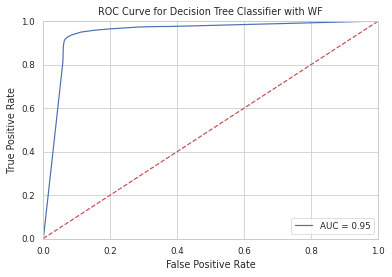

time: 1min 26s (started: 2021-03-19 19:48:38 +00:00)


In [ ]:
# Decision tree model fitting and predictions
dt = DecisionTreeClassifier().fit(X_train_bow, y_train)
y_pred_train_dtbow = dt.predict(X_train_bow)
y_pred_test_dtbow = dt.predict(X_test_bow)

# Save results
bow_results.append({
        'classifier_name': 'Decision Tree Classifier',
        'train accuracy': round(accuracy_score(y_train, y_pred_train_dtbow) * 100, 2),
        'test accuracy': round(accuracy_score(y_test, y_pred_test_dtbow) * 100, 2),
        'recall': round(recall_score(y_test, y_pred_test_dtbow), 2),
        'precision': round(precision_score(y_test, y_pred_test_dtbow), 2)
    })

# Plot ROC
roc_plot(dt, 'Decision Tree Classifier with WF', X_test_bow, y_test)

#### Random Forest

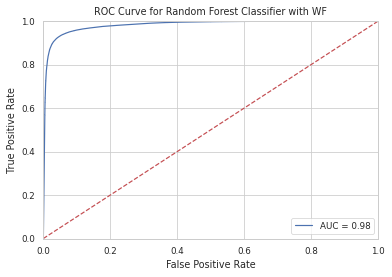

time: 13min 19s (started: 2021-03-19 19:50:04 +00:00)


In [ ]:
# Random forest model fitting and predictions
rf = RandomForestClassifier().fit(X_train_bow, y_train)
y_pred_train_rfbow = rf.predict(X_train_bow)
y_pred_test_rfbow = rf.predict(X_test_bow)

# Save results
bow_results.append({
        'classifier_name': 'Random Forest Classifier',
        'train accuracy': round(accuracy_score(y_train, y_pred_train_rfbow) * 100, 2),
        'test accuracy': round(accuracy_score(y_test, y_pred_test_rfbow) * 100, 2),
        'recall': round(recall_score(y_test, y_pred_test_rfbow), 2),
        'precision': round(precision_score(y_test, y_pred_test_rfbow), 2)
    })

# Plot ROC
roc_plot(rf, 'Random Forest Classifier with WF', X_test_bow, y_test)

#### XGBoost

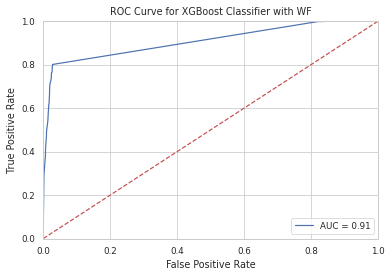

time: 14.8 s (started: 2021-03-19 20:03:23 +00:00)


In [ ]:
# XGBoost model fitting and predictions
xgb = XGBClassifier().fit(X_train_bow, y_train)
y_pred_train_xgbbow = xgb.predict(X_train_bow)
y_pred_test_xgbbow = xgb.predict(X_test_bow)

# Save results
bow_results.append({
        'classifier_name': 'XGBoost Classifier',
        'train accuracy': round(accuracy_score(y_train, y_pred_train_xgbbow) * 100, 2),
        'test accuracy': round(accuracy_score(y_test, y_pred_test_xgbbow) * 100, 2),
        'recall': round(recall_score(y_test, y_pred_test_xgbbow), 2),
        'precision': round(precision_score(y_test, y_pred_test_xgbbow), 2)
    })

# Plot ROC
roc_plot(xgb, 'XGBoost Classifier with WF', X_test_bow, y_test)

In [ ]:
bow_results = pd.DataFrame(bow_results)
bow_results

,classifier_name,train accuracy,test accuracy,recall,precision
0,Logistic Regression,94.35,94.25,0.95,0.97
1,kNN Classifier,93.90,91.83,0.91,0.96
2,Naive Bayes Classifier,90.04,90.00,0.96,0.90
3,Linear SVC Classifier,94.08,94.00,0.94,0.97
4,Decision Tree Classifier,98.34,92.93,0.94,0.95
5,Random Forest Classifier,98.34,94.09,0.95,0.96
6,XGBoost Classifier,85.59,85.61,0.80,0.98


time: 23.5 ms (started: 2021-03-19 20:03:38 +00:00)


Looking at the results generated by models using the bag-of-words approach, we can see that Logistic Regression has the highest testing accuracy.

### TF-IDF Train-Test Sets

In [ ]:
# Initialize list for results
tfidf_results = []

time: 774 µs (started: 2021-03-19 13:59:19 +00:00)


#### Logistic Regression

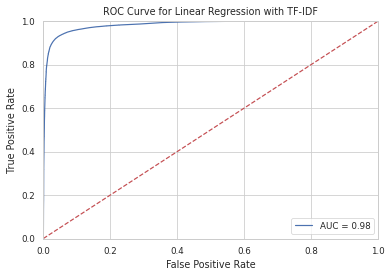

time: 3.88 s (started: 2021-03-19 13:59:19 +00:00)


In [ ]:
# Logistic regression model fitting and predictions
lr2 = LogisticRegression(penalty='l2', solver='newton-cg').fit(X_train_tfidf, y_train)
y_pred_train_lrtfidf = lr2.predict(X_train_tfidf)
y_pred_test_lrtfidf = lr2.predict(X_test_tfidf)

# Save results
tfidf_results.append({
        'classifier_name': 'Logistic Regression',
        'train accuracy': round(accuracy_score(y_train, y_pred_train_lrtfidf) * 100, 2),
        'test accuracy': round(accuracy_score(y_test, y_pred_test_lrtfidf) * 100, 2),
        'recall': round(recall_score(y_test, y_pred_test_lrtfidf), 2),
        'precision': round(precision_score(y_test, y_pred_test_lrtfidf), 2)
    })

# Plot ROC
roc_plot(lr2, 'Linear Regression with TF-IDF', X_test_tfidf, y_test)

#### k-NN

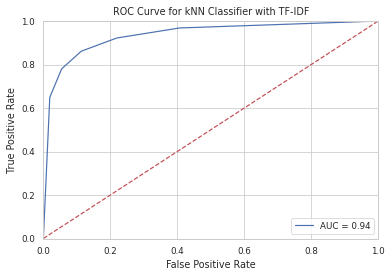

time: 1h 12min 18s (started: 2021-03-19 13:59:23 +00:00)


In [ ]:
# kNN model fitting and predictions
knn2 = KNeighborsClassifier(n_neighbors=5).fit(X_train_tfidf, y_train)
y_pred_train_knntfidf = knn2.predict(X_train_tfidf)
y_pred_test_knntfidf = knn2.predict(X_test_tfidf)

# Save results
tfidf_results.append({
        'classifier_name': 'kNN Classifier',
        'train accuracy': round(accuracy_score(y_train, y_pred_train_knntfidf) * 100, 2),
        'test accuracy': round(accuracy_score(y_test, y_pred_test_knntfidf) * 100, 2),
        'recall': round(recall_score(y_test, y_pred_test_knntfidf), 2),
        'precision': round(precision_score(y_test, y_pred_test_knntfidf), 2)
    })

# Plot ROC
roc_plot(knn2, 'kNN Classifier with TF-IDF', X_test_tfidf, y_test)

#### Naive Bayes

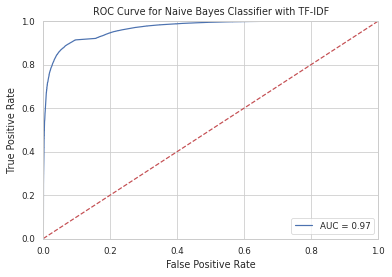

time: 552 ms (started: 2021-03-19 15:11:42 +00:00)


In [ ]:
# Naive bayes model fitting and predictions
nb2 = MultinomialNB().fit(X_train_tfidf, y_train)
y_pred_train_nbtfidf = nb2.predict(X_train_tfidf)
y_pred_test_nbtfidf = nb2.predict(X_test_tfidf)

# Save results
tfidf_results.append({
        'classifier_name': 'Naive Bayes Classifier',
        'train accuracy': round(accuracy_score(y_train, y_pred_train_nbtfidf) * 100, 2),
        'test accuracy': round(accuracy_score(y_test, y_pred_test_nbtfidf) * 100, 2),
        'recall': round(recall_score(y_test, y_pred_test_nbtfidf), 2),
        'precision': round(precision_score(y_test, y_pred_test_nbtfidf), 2)
    })

# Plot ROC
roc_plot(nb2, 'Naive Bayes Classifier with TF-IDF', X_test_tfidf, y_test)

#### SVM (Linear SVC)

In [ ]:
# Linear SVC model fitting and predictions
svc2 = LinearSVC(loss='hinge', penalty='l2').fit(X_train_tfidf, y_train)
y_pred_train_svctfidf = svc2.predict(X_train_tfidf)
y_pred_test_svctfidf = svc2.predict(X_test_tfidf)

# Save results
tfidf_results.append({
        'classifier_name': 'Linear SVC Classifier',
        'train accuracy': round(accuracy_score(y_train, y_pred_train_svctfidf) * 100, 2),
        'test accuracy': round(accuracy_score(y_test, y_pred_test_svctfidf) * 100, 2),
        'recall': round(recall_score(y_test, y_pred_test_svctfidf), 2),
        'precision': round(precision_score(y_test, y_pred_test_svctfidf), 2)
    })

# Plot ROC
# roc_plot(svc2, 'Linear SVC Classifier with TF-IDF', X_test_tfidf, y_test)

time: 1.58 s (started: 2021-03-19 15:11:42 +00:00)


#### Decision Trees

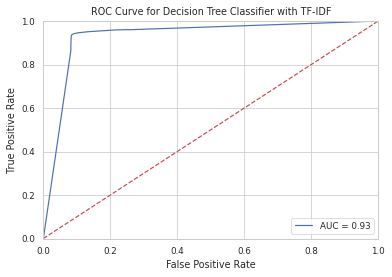

time: 1min 1s (started: 2021-03-19 15:11:44 +00:00)


In [ ]:
# Decision tree model fitting and predictions
dt2 = DecisionTreeClassifier().fit(X_train_tfidf, y_train)
y_pred_train_dttfidf = dt2.predict(X_train_tfidf)
y_pred_test_dttfidf = dt2.predict(X_test_tfidf)

# Save results
tfidf_results.append({
        'classifier_name': 'Decision Tree Classifier',
        'train accuracy': round(accuracy_score(y_train, y_pred_train_dttfidf) * 100, 2),
        'test accuracy': round(accuracy_score(y_test, y_pred_test_dttfidf) * 100, 2),
        'recall': round(recall_score(y_test, y_pred_test_dttfidf), 2),
        'precision': round(precision_score(y_test, y_pred_test_dttfidf), 2)
    })

# Plot ROC
roc_plot(dt2, 'Decision Tree Classifier with TF-IDF', X_test_tfidf, y_test)

#### Random Forest

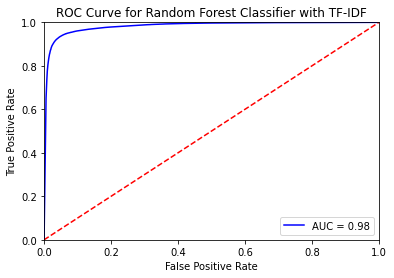

time: 12min 46s (started: 2021-03-20 04:30:04 +00:00)


In [ ]:
# Random forest model fitting and predictions
rf2 = RandomForestClassifier().fit(X_train_tfidf, y_train)
y_pred_train_rftfidf = rf2.predict(X_train_tfidf)
y_pred_test_rftfidf = rf2.predict(X_test_tfidf)

# Save results
tfidf_results.append({
        'classifier_name': 'Random Forest Classifier',
        'train accuracy': round(accuracy_score(y_train, y_pred_train_rftfidf) * 100, 2),
        'test accuracy': round(accuracy_score(y_test, y_pred_test_rftfidf) * 100, 2),
        'recall': round(recall_score(y_test, y_pred_test_rftfidf), 2),
        'precision': round(precision_score(y_test, y_pred_test_rftfidf), 2)
    })

# Plot ROC
roc_plot(rf2, 'Random Forest Classifier with TF-IDF', X_test_tfidf, y_test)

#### XGBoost

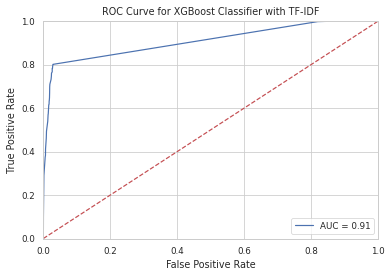

time: 18.7 s (started: 2021-03-19 15:25:06 +00:00)


In [ ]:
# XGBoost model fitting and predictions
xgb2 = XGBClassifier().fit(X_train_tfidf, y_train)
y_pred_train_xgbtfidf = xgb2.predict(X_train_tfidf)
y_pred_test_xgbtfidf = xgb2.predict(X_test_tfidf)

# Save results
tfidf_results.append({
        'classifier_name': 'XGBoost Classifier',
        'train accuracy': round(accuracy_score(y_train, y_pred_train_xgbtfidf) * 100, 2),
        'test accuracy': round(accuracy_score(y_test, y_pred_test_xgbtfidf) * 100, 2),
        'recall': round(recall_score(y_test, y_pred_test_xgbtfidf), 2),
        'precision': round(precision_score(y_test, y_pred_test_xgbtfidf), 2)
    })

# Plot ROC
roc_plot(xgb2, 'XGBoost Classifier with TF-IDF', X_test_tfidf, y_test)

In [ ]:
tfidf_results = pd.DataFrame(tfidf_results)
tfidf_results

,classifier_name,train accuracy,test accuracy,recall,precision
0,Logistic Regression,94.32,94.23,0.95,0.96
1,kNN Classifier,90.79,86.97,0.86,0.94
2,Naive Bayes Classifier,89.08,89.03,0.97,0.88
3,Linear SVC Classifier,94.18,94.11,0.95,0.97
4,Decision Tree Classifier,98.33,93.11,0.94,0.96
5,Random Forest Classifier,98.33,94.35,0.95,0.96
6,XGBoost Classifier,85.60,85.62,0.80,0.98


time: 16.2 ms (started: 2021-03-19 15:25:25 +00:00)


Although the Random Forest with TF-IDF model outperforms the others, it only exceeds the Logistic Regression with WF model by around 0.1%. Thus, considering the computational complexity, we will proceed with the Logistic Regression model for further tuning.

##### Bonus: Hyperparameter Tuning for Logistic Regression with WF

In [ ]:
# Prepare parameter_grid
solvers = ['newton-cg', 'lbfgs', 'liblinear']
penalty = ['l2', 'l1']
c_values = [100, 10, 1.0, 0.1, 0.01]

param_grid = {'solver': solvers,
              'penalty': penalty,
              'C': c_values}

# 5-fold Grid search CV
lr_cv = GridSearchCV(estimator = lr, param_grid = param_grid, cv = 5)
lr_cv.fit(X_train_bow, y_train)
lr_cv.best_params_

{'C': 10, 'penalty': 'l2', 'solver': 'lbfgs'}

time: 4min 46s (started: 2021-03-20 04:50:36 +00:00)


classifier_name: Logistic Regression Classifier 
 train accuracy: 94.37 
 test accuracy: 94.26 
 recall: 0.95 
 precision: 0.97


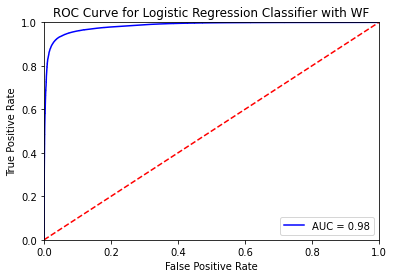

time: 5.21 s (started: 2021-03-21 19:48:39 +00:00)


In [ ]:
# Random forest model fitting and predictions
lr3 = LogisticRegression(solver='lbfgs',
                         penalty='l2',
                         C=10).fit(X_train_bow, y_train)
y_pred_train_lrbow = lr3.predict(X_train_bow)
y_pred_test_lrbow = lr3.predict(X_test_bow)

# Print results
print('classifier_name: Logistic Regression Classifier', '\n',
      'train accuracy:', round(accuracy_score(y_train, y_pred_train_lrbow) * 100, 2), '\n',
      'test accuracy:', round(accuracy_score(y_test, y_pred_test_lrbow) * 100, 2), '\n',
      'recall:', round(recall_score(y_test, y_pred_test_lrbow), 2), '\n',
      'precision:', round(precision_score(y_test, y_pred_test_lrbow), 2))

# Plot ROC
roc_plot(lr3, 'Logistic Regression Classifier with WF', X_test_bow, y_test)

## Model Evaluation on Canadian Election Data

By tuning the hyperparameter with Grid Search CV, the Logistic regression with WF vectorizer slightly outperforms the other models. Hence, we will proceed to use this model for evaluating the Canadian Election data.

In [ ]:
# Convert sentiment labels in the Canadian elections data to binary numbers
Canadian_elections_df.sentiment = Canadian_elections_df.sentiment.apply(lambda x: 1 if x == 'positive' else 0)
Canadian_elections_df.head()

,sentiment,negative_reason,text,Party
0,0,Women Reproductive right and Racism,instead suggestion agree canadian women trust andrewscheer conservatives government protect woman right automony body let cdnpoli elxn canada abortion,Conservative
1,1,NaN,allwomanspacewalk real station etobicokenorth cityofto onpoli cdnpoli elxn,Others
2,0,Economy,brantford going cost billion next years ask justin elxn cdnpoli canada,Liberal
3,1,NaN,canada canadaelection canadavotes elxn decide help,Others
4,0,Economy,canada taxpayers sick amp tired hard earned donated corporate welfare bums need one many reasons trudeaumustgo leave canada care copps snclavalinscandal election elxn cdnpoli,Others


time: 17.6 ms (started: 2021-03-21 19:48:13 +00:00)


In [ ]:
# Prepare election data
Canadian_elections_copy = Canadian_elections_df.copy(deep=True)
X = Canadian_elections_copy.text
y = Canadian_elections_copy.sentiment
y = np.array(y).reshape(-1,1)

# Use fitted TfidfVectorizer to transform the X features
X = tfidf.transform(X)
print(X.shape)

(2133, 1200)
time: 44 ms (started: 2021-03-21 19:48:13 +00:00)


### Visualizing Election Sentiment Prediction Results

In [ ]:
# use the tuned logistic regression model to predict the entire Canadian election data
y_pred = lr3.predict(X)

# Compare results with labels
col_to_move = ['sentiment']
Canadian_elections_copy = Canadian_elections_copy[[col for col in Canadian_elections_copy.columns if col not in col_to_move] + col_to_move]
Canadian_elections_copy['Predicted'] = y_pred
Canadian_elections_copy.head(10)

,negative_reason,text,Party,sentiment,Predicted
0,Women Reproductive right and Racism,instead suggestion agree canadian women trust andrewscheer conservatives government protect woman right automony body let cdnpoli elxn canada abortion,Conservative,0,0
1,NaN,allwomanspacewalk real station etobicokenorth cityofto onpoli cdnpoli elxn,Others,1,0
2,Economy,brantford going cost billion next years ask justin elxn cdnpoli canada,Liberal,0,0
3,NaN,canada canadaelection canadavotes elxn decide help,Others,1,0
4,Economy,canada taxpayers sick amp tired hard earned donated corporate welfare bums need one many reasons trudeaumustgo leave canada care copps snclavalinscandal election elxn cdnpoli,Others,0,0
5,Others,canadavotes elxn cdnpoli facts blastfromthepast conservatives introduced end long gun registry even though heads police across canada victims groups objected crime control public safety gunlobby,Conservative,0,0
6,NaN,cdnmedia elxn cdnpoli ppc rocky dong hands best election video ever please google rocky dong boxes socialism seen rocky,Others,1,1
7,NaN,cdnpoli elxn liberals double promised national debt next term elected forecasting billion national pharmacare program incl ndp coalition billion seems possible imo,Liberal,1,0
8,Others,chooseforward cdnpoli elxn canada make america mistakes full frontal tbs via,Liberal,0,0
9,Scandal,cpckinsellagatelet see receipts pays warren kinsella make sleaze cdnpoli elxn voteliberal chooseforward,Liberal,0,0


time: 21.9 ms (started: 2021-03-21 19:48:52 +00:00)


In [ ]:
print('Metrics for the election sentiment prediction:', '\n',
      'accuracy:', round(accuracy_score(y, y_pred) * 100, 2),'%' '\n',
      'recall:', round(recall_score(y, y_pred), 2), '\n',
      'precision:', round(precision_score(y, y_pred), 2))

Metrics for the election sentiment prediction: 
 accuracy: 56.92 %
 recall: 0.26 
 precision: 0.78
time: 10.4 ms (started: 2021-03-21 19:48:59 +00:00)


Implementing the best model (Logistic Regression with WF) from the sentiment analysis section to the Canadian election data does not seem to yield great results. The model produces predictions with an accuracy of only 56.92%, with a recall of 0.26 and a precision of 0.78. We will explore these results further below by looking at predictions associated with the three separate parties.

In [ ]:
# Create function for displaying metrics for parties
def party_results(Canadian_party):
    # Metrics
    df = Canadian_elections_copy[Canadian_elections_copy.Party == Canadian_party]
    print('Party name:', Canadian_party, '\n',
          'accuracy:', round(accuracy_score(df.sentiment, df.Predicted) * 100, 2),'%' '\n',
          'recall:', round(recall_score(df.sentiment, df.Predicted), 2), '\n',
          'precision:', round(precision_score(df.sentiment, df.Predicted), 2))
    
    # Plot confusion matrix
    from sklearn.metrics import plot_confusion_matrix

    mat = confusion_matrix(df.sentiment, df.Predicted)
    group_names = ['TN', 'FP', 'FN', 'TP']
    # Calculate each label counts
    group_counts = ["{0:0.0f}".format(value) for value in mat.flatten()]
    # Calculate each label precision
    group_precision = ['{0:.2f}'.format(value) for value in (mat/mat.astype(np.float).sum(axis=0)).flatten()]
    labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in zip(group_names, group_counts, group_precision)]
    labels = np.asarray(labels).reshape(2,2)
    ax = sns.heatmap(mat, annot=labels, linewidths=1, fmt='', annot_kws={"fontsize":12}, cmap='Blues', cbar=False)
    ax.set(xlabel='True Sentiment', ylabel='Predicted Sentiment', title='Confusion Matrix (with Precision)')

time: 21.2 ms (started: 2021-03-21 20:15:16 +00:00)


In [ ]:
# Masks
true_pos = (Canadian_elections_copy.sentiment == 1)
true_neg = (Canadian_elections_copy.sentiment == 0)
pred_pos = (Canadian_elections_copy.Predicted == 1)
pred_neg = (Canadian_elections_copy.Predicted == 0)
liberal = (Canadian_elections_copy.Party == 'Liberal')
conservative = (Canadian_elections_copy.Party == 'Conservative')
ndp = (Canadian_elections_copy.Party == 'NDP')

time: 12.6 ms (started: 2021-03-21 20:10:42 +00:00)


In [ ]:
# Save predictions and true labels
party_dict = []

party_dict.append({
    'party_name': 'Liberal',
    'true_positive': Canadian_elections_copy[true_pos][liberal].shape[0],
    'predicted_positive': Canadian_elections_copy[pred_pos][liberal].shape[0],
    'true_negative': Canadian_elections_copy[true_neg][liberal].shape[0],
    'predicted_negative': Canadian_elections_copy[pred_neg][liberal].shape[0]
})

party_dict.append({
    'party_name': 'Conservative',
    'true_positive': Canadian_elections_copy[true_pos][conservative].shape[0],
    'predicted_positive': Canadian_elections_copy[pred_pos][conservative].shape[0],
    'true_negative': Canadian_elections_copy[true_neg][conservative].shape[0],
    'predicted_negative': Canadian_elections_copy[pred_neg][conservative].shape[0]
})

party_dict.append({
    'party_name': 'NDP',
    'true_positive': Canadian_elections_copy[true_pos][ndp].shape[0],
    'predicted_positive': Canadian_elections_copy[pred_pos][ndp].shape[0],
    'true_negative': Canadian_elections_copy[true_neg][ndp].shape[0],
    'predicted_negative': Canadian_elections_copy[pred_neg][ndp].shape[0]
})

party_dict = pd.DataFrame(party_dict)
party_dict

,party_name,true_positive,predicted_positive,true_negative,predicted_negative
0,Liberal,241,92,205,354
1,Conservative,116,45,268,339
2,NDP,65,21,32,76


time: 40 ms (started: 2021-03-21 20:57:17 +00:00)


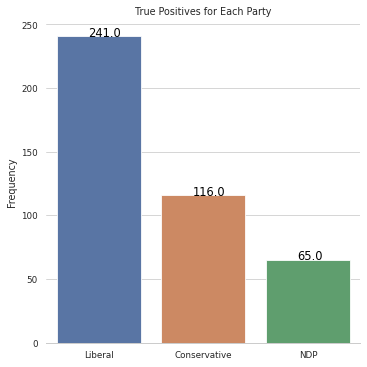

time: 353 ms (started: 2021-03-21 20:48:48 +00:00)


In [ ]:
# True positives
sns.set_theme(style="whitegrid")
sns.set_context("paper")
ax = sns.catplot(x='party_name', y='true_positive', data=party_dict, kind='bar')
ax.set(xlabel='', ylabel='Frequency', title='True Positives for Each Party')
ax.despine(left=True)
ax = ax.facet_axis(0,0)
for p in ax.patches:
    ax.text(p.get_x() + 0.3, 
            int(p.get_height()), 
            p.get_height(),
            color='black', 
            rotation='horizontal', 
            size='large')

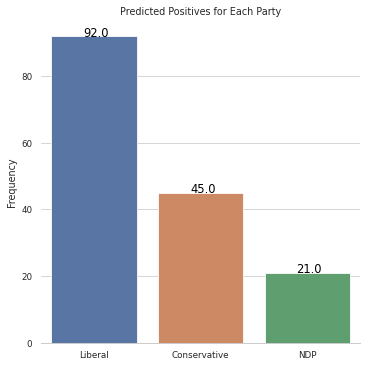

time: 341 ms (started: 2021-03-21 20:49:54 +00:00)


In [ ]:
# Predicted positives
sns.set_theme(style="whitegrid")
sns.set_context("paper")
ax = sns.catplot(x='party_name', y='predicted_positive', data=party_dict, kind='bar')
ax.set(xlabel='', ylabel='Frequency', title='Predicted Positives for Each Party')
ax.despine(left=True)
ax = ax.facet_axis(0,0)
for p in ax.patches:
    ax.text(p.get_x() + 0.3, 
            int(p.get_height()), 
            p.get_height(),
            color='black', 
            rotation='horizontal', 
            size='large')

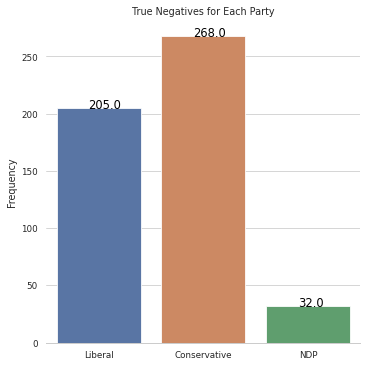

time: 352 ms (started: 2021-03-21 20:50:21 +00:00)


In [ ]:
# True negatives
sns.set_theme(style="whitegrid")
sns.set_context("paper")
ax = sns.catplot(x='party_name', y='true_negative', data=party_dict, kind='bar')
ax.set(xlabel='', ylabel='Frequency', title='True Negatives for Each Party')
ax.despine(left=True)
ax = ax.facet_axis(0,0)
for p in ax.patches:
    ax.text(p.get_x() + 0.3, 
            int(p.get_height()), 
            p.get_height(),
            color='black', 
            rotation='horizontal', 
            size='large')

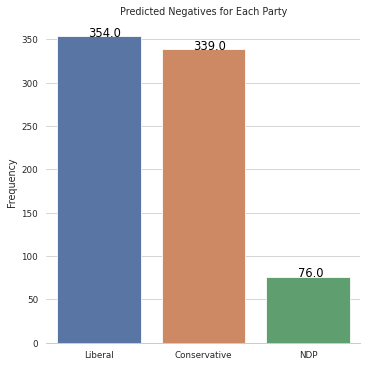

time: 347 ms (started: 2021-03-21 20:51:06 +00:00)


In [ ]:
# Predicted negatives
sns.set_theme(style="whitegrid")
sns.set_context("paper")
ax = sns.catplot(x='party_name', y='predicted_negative', data=party_dict, kind='bar')
ax.set(xlabel='', ylabel='Frequency', title='Predicted Negatives for Each Party')
ax.despine(left=True)
ax = ax.facet_axis(0,0)
for p in ax.patches:
    ax.text(p.get_x() + 0.3, 
            int(p.get_height()), 
            p.get_height(),
            color='black', 
            rotation='horizontal', 
            size='large')

#### Liberal Party

Party name: Liberal 
 accuracy: 58.52 %
 recall: 0.31 
 precision: 0.8


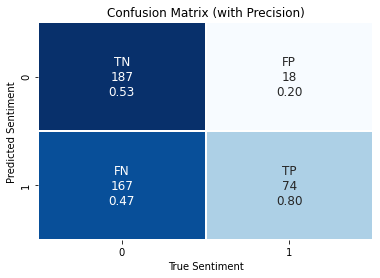

time: 159 ms (started: 2021-03-20 20:03:19 +00:00)


In [ ]:
party_results('Liberal')

#### Conservative Party

Party name: Conservative 
 accuracy: 72.14 %
 recall: 0.23 
 precision: 0.6


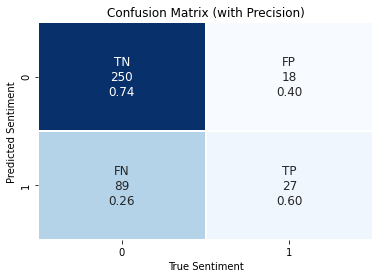

time: 167 ms (started: 2021-03-20 20:03:22 +00:00)


In [ ]:
party_results('Conservative')

#### New Democratic Party

Party name: NDP 
 accuracy: 46.39 %
 recall: 0.26 
 precision: 0.81


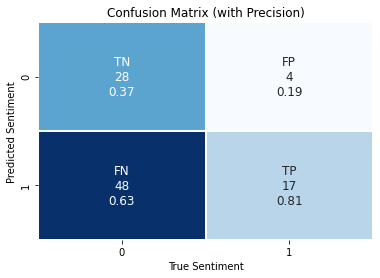

time: 157 ms (started: 2021-03-20 20:03:25 +00:00)


In [ ]:
party_results('NDP')

As we can see from the above confusion matrices for the three Canadian parties, it is safe to say that using sentiment analysis based on tweets can be somewhat useful for political parties during election campaign.

Accuracies are significantly lower than the sentiment analysis prediction due to the fact that the model is trained on the sentiment analysis data before testing on the Canadian election data. Overall accuracy of the predictions generated by the best model is around 56.92%, while the accuracies for the political parties are: Liberal 58.52%, Conservative 72.14%, NDP 46.39%.

Recall (TP/(TP+FN)) scores are low, which indicates that most of the positive labels have not been predicted by the model in this case. However, the model produces relatively acceptable precision scores (around 0.6 to 0.8), meaning that most of the predicted 'positive sentiment' labels are correct when compared to the true labels. As a result, the political parties can use this metric to assess or approximate the positive attitude of the voting population towards the parties during election.

### Predicting Reasons for Negative Tweets

Using the true sentiment labels in the Canadian elections data to separate out the negative tweets data, then use this data to construct models for the prediction of negative reasons.

In [ ]:
negative_df = Canadian_elections_df.copy(deep=True)
negative_df = negative_df[negative_df.sentiment == 0]
negative_df.drop(columns=['sentiment', 'Party'], inplace=True)
negative_df.head()

,negative_reason,text
0,Women Reproductive right and Racism,instead suggestion agree canadian women trust andrewscheer conservatives government protect woman right automony body let cdnpoli elxn canada abortion
2,Economy,brantford going cost billion next years ask justin elxn cdnpoli canada
4,Economy,canada taxpayers sick amp tired hard earned donated corporate welfare bums need one many reasons trudeaumustgo leave canada care copps snclavalinscandal election elxn cdnpoli
5,Others,canadavotes elxn cdnpoli facts blastfromthepast conservatives introduced end long gun registry even though heads police across canada victims groups objected crime control public safety gunlobby
8,Others,chooseforward cdnpoli elxn canada make america mistakes full frontal tbs via


time: 22.2 ms (started: 2021-03-20 22:23:51 +00:00)


In [ ]:
negative_df.negative_reason.value_counts()

Others                                 364
Scandal                                270
Tell lies                              198
Economy                                 51
Women Reproductive right and Racism     45
Climate Problem                         41
Separation                              16
Privilege                               12
Healthcare                               5
Healthcare and Marijuana                 4
Name: negative_reason, dtype: int64

time: 9.81 ms (started: 2021-03-20 22:23:54 +00:00)


From the above frequency counts for different negative reasons, we can see that some of the negative reasons such as 'Separation', 'Privilege', 'Healthcare', and 'Healthcare and Marijuana' have very low frequencies. Thus, we can group these negative reasons based on their broader categories for classification.

In [ ]:
# Combining less frequent reasons into the 'Others' category
reasons_ = {'Scandal': 'Political',
            'Tell lies': 'Political',
            'Economy': 'Economy',
            'Women Reproductive right and Racism': 'Women Rights and Racism',
            'Climate Problem': 'Climate Problem',
            'Others': 'Others',
            'Separation': 'Political',
            'Privilege': 'Political',
            'Healthcare': 'Healthcare',
            'Healthcare and Marijuana': 'Healthcare'}
negative_df['negative_reason'] = negative_df.negative_reason.map(reasons_)

# Encoding based on frequency in the data
negative_encode = {'Political': 1,
                   'Healthcare': 2,
                   'Economy': 3,
                   'Women Rights and Racism': 4,
                   'Climate Problem': 5,
                   'Others': 6}
negative_df['negative_reason_encoded'] = negative_df.negative_reason.map(negative_encode)
negative_df.negative_reason_encoded.value_counts()

1    496
6    364
3     51
4     45
5     41
2      9
Name: negative_reason_encoded, dtype: int64

time: 21.1 ms (started: 2021-03-20 22:23:57 +00:00)


In [ ]:
negative_df.negative_reason_encoded.unique()

array([4, 3, 6, 1, 5, 2])

time: 9.3 ms (started: 2021-03-20 22:24:00 +00:00)


Here the stratify parameter of the train_test_split is set to 'y' because the multi-class data is unbalanced. Stratified sampling during splitting can help maintain the relative distributions within train and tset sets.

In [ ]:
# Split negative sentiment election data into training (70%) and testing (30%) sets
negative_copy = negative_df.copy(deep=True)
X = negative_copy.text
y = negative_copy.negative_reason_encoded
y = np.array(y).reshape(-1,1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=1)

time: 12.6 ms (started: 2021-03-20 22:40:36 +00:00)


In [ ]:
# Use CountVectorizer for bag-of-words approach
bow = CountVectorizer(max_features=1200, analyzer='word', token_pattern=r'\w+',
                      stop_words='english', ngram_range=(1, 1))
X_train = bow.fit_transform(X_train)
X_test = bow.transform(X_test)

time: 39.3 ms (started: 2021-03-20 22:40:36 +00:00)


In [ ]:
target_reason = ['Political', 'Healthcare', 'Economy', 'Women Rights and Racism', 'Climate Problem', 'Others']

time: 1.93 ms (started: 2021-03-20 22:24:05 +00:00)


Some of the models have an additional 'class_weight' parameter set to 'balanced' because we have a multiclass situation in which the class frequencies are unbalance. Setting class weight would help balance the differences between classes.

F1 score is used in the grid search because of the presence of class imbalance within the multiclass dataset. Simply looking at accuracy might not be sufficient in this case because of different class sizes. In order to obtain a best model, evaluating F1 score is a good way to balance precision and recall.

Here 'f1_weighted' is used because it calculates metrics for each label, and find their average weighted by support (the number of true instances for each label). This accounts for label imbalance in the data.

#### Logistic Regression with GridSearchCV

In [ ]:
# Prepare parameter_grid
solvers = ['newton-cg', 'lbfgs', 'liblinear', 'saga']
penalty = ['l2', 'l1', 'elasticnet']
c_values = [10, 1.0, 0.1, 0.01, 0.001]

param_grid = {'solver': solvers,
              'penalty': penalty,
              'C': c_values}

# 5-fold Grid search CV
lr = LogisticRegression(class_weight='balanced', multi_class='auto')
lr_cv = GridSearchCV(estimator = lr, param_grid = param_grid, cv = 5, scoring = 'f1_weighted')
lr_cv.fit(X_train, y_train)
print('Best hyperparameters:', lr_cv.best_params_)
print('Best weighted F1 score:', lr_cv.best_score_)

Best hyperparameters: {'C': 0.1, 'penalty': 'l2', 'solver': 'newton-cg'}
Best weighted F1 score: 0.5746108420306305
time: 11.5 s (started: 2021-03-20 22:43:14 +00:00)


In [ ]:
# Random forest model fitting and predictions
lr4 = LogisticRegression(solver='newton-cg',
                         penalty='l2',
                         C=0.1,
                         class_weight='balanced',
                         multi_class='auto').fit(X_train, y_train)
y_pred_train = lr4.predict(X_train)
y_pred_test = lr4.predict(X_test)

# Print results
print('classifier_name: Logistic Regression Classifier', '\n',
      'train accuracy:', round(accuracy_score(y_train, y_pred_train) * 100, 2), '%', '\n',
      'test accuracy:', round(accuracy_score(y_test, y_pred_test) * 100, 2), '%', '\n',
      'F1 score:', round(f1_score(y_test, y_pred_test, average='weighted'), 2))

# Print classification report
print(classification_report(y_test, y_pred_test, target_names=target_reason))

classifier_name: Logistic Regression Classifier 
 train accuracy: 83.38 % 
 test accuracy: 62.91 % 
 F1 score: 0.63
                         precision    recall  f1-score   support

              Political       0.75      0.59      0.66       149
             Healthcare       0.00      0.00      0.00         3
                Economy       0.60      0.60      0.60        15
Women Rights and Racism       0.50      0.36      0.42        14
        Climate Problem       0.57      0.67      0.62        12
                 Others       0.55      0.73      0.63       109

               accuracy                           0.63       302
              macro avg       0.50      0.49      0.49       302
           weighted avg       0.64      0.63      0.63       302

time: 106 ms (started: 2021-03-20 22:44:06 +00:00)


#### Bonus Visualizations

[Text(33.0, 0.5, 'Predicted Reason'),
 Text(0.5, 15.0, 'True Reason'),
 Text(0.5, 1.0, 'Confusion Matrix (with Precision)')]

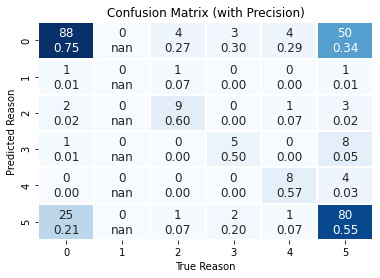

time: 334 ms (started: 2021-03-20 22:44:14 +00:00)


In [ ]:
# Plot confusion matrix
from sklearn.metrics import plot_confusion_matrix

mat = confusion_matrix(y_test, y_pred_test)
# Calculate each label counts
group_counts = ["{0:0.0f}".format(value) for value in mat.flatten()]
# Calculate each label precision
group_precision = ['{0:.2f}'.format(value) for value in (mat/mat.astype(np.float).sum(axis=0)).flatten()]
labels = [f'{v2}\n{v3}' for v2, v3 in zip(group_counts, group_precision)]
labels = np.asarray(labels).reshape(6,6)
ax = sns.heatmap(mat, annot=labels, linewidths=1, fmt='', annot_kws={"fontsize":12}, cmap='Blues', cbar=False)
ax.set(xlabel='True Reason', ylabel='Predicted Reason', title='Confusion Matrix (with Precision)')

#### Naive Bayes with GridSearchCV

In [ ]:
# Prepare parameter_grid
alpha_range = np.arange(0, 6, 1.5)
fit_prior = [True, False]

param_grid = {'alpha': alpha_range,
              'fit_prior': fit_prior}

# 5-fold Grid search CV
nb = MultinomialNB()
nb_cv = GridSearchCV(estimator = nb, param_grid = param_grid, cv = 5, scoring = 'f1_weighted')
nb_cv.fit(X_train, y_train)
print('Best hyperparameters:', nb_cv.best_params_)
print('Best weighted F1 score:', nb_cv.best_score_)

Best hyperparameters: {'alpha': 1.5, 'fit_prior': True}
Best weighted F1 score: 0.5552139414843035
time: 118 ms (started: 2021-03-20 22:43:39 +00:00)


In [ ]:
# Naive Bayes model fitting and predictions
nb3 = MultinomialNB(alpha=1.5,
                    fit_prior=True).fit(X_train, y_train)
y_pred_train = nb3.predict(X_train)
y_pred_test = nb3.predict(X_test)

# Print results
print('classifier_name: Naive Bayes Classifier', '\n',
      'train accuracy:', round(accuracy_score(y_train, y_pred_train) * 100, 2), '%', '\n',
      'test accuracy:', round(accuracy_score(y_test, y_pred_test) * 100, 2), '%', '\n',
      'F1 score:', round(f1_score(y_test, y_pred_test, average='weighted'), 2))

# Print classification report
print(classification_report(y_test, y_pred_test, target_names=target_reason))

classifier_name: Naive Bayes Classifier 
 train accuracy: 85.23 % 
 test accuracy: 60.26 % 
 F1 score: 0.58
                         precision    recall  f1-score   support

              Political       0.63      0.80      0.70       149
             Healthcare       0.00      0.00      0.00         3
                Economy       0.67      0.13      0.22        15
Women Rights and Racism       1.00      0.14      0.25        14
        Climate Problem       1.00      0.33      0.50        12
                 Others       0.53      0.50      0.52       109

               accuracy                           0.60       302
              macro avg       0.64      0.32      0.37       302
           weighted avg       0.62      0.60      0.58       302

time: 23 ms (started: 2021-03-20 22:44:37 +00:00)


#### Bonus Visualizations

[Text(33.0, 0.5, 'Predicted Reason'),
 Text(0.5, 15.0, 'True Reason'),
 Text(0.5, 1.0, 'Confusion Matrix (with Precision)')]

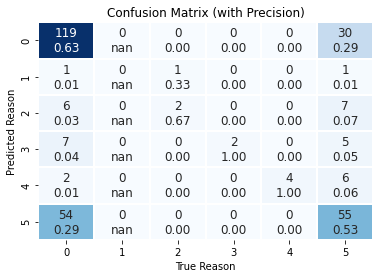

time: 314 ms (started: 2021-03-20 22:44:40 +00:00)


In [ ]:
# Plot confusion matrix
from sklearn.metrics import plot_confusion_matrix

mat = confusion_matrix(y_test, y_pred_test)
# Calculate each label counts
group_counts = ["{0:0.0f}".format(value) for value in mat.flatten()]
# Calculate each label precision
group_precision = ['{0:.2f}'.format(value) for value in (mat/mat.astype(np.float).sum(axis=0)).flatten()]
labels = [f'{v2}\n{v3}' for v2, v3 in zip(group_counts, group_precision)]
labels = np.asarray(labels).reshape(6,6)
ax = sns.heatmap(mat, annot=labels, linewidths=1, fmt='', annot_kws={"fontsize":12}, cmap='Blues', cbar=False)
ax.set(xlabel='True Reason', ylabel='Predicted Reason', title='Confusion Matrix (with Precision)')

#### Linear SVC with GridSearchCV

In [ ]:
# Prepare parameter_grid
c_range = [0.01, 0.1, 1, 10, 100]
penalty = ['l1', 'l2']
loss = ['hinge', 'squared_hinge']

param_grid = {'C': c_range,
              'penalty': penalty,
              'loss': loss}

# 5-fold Grid search CV
svc = LinearSVC()
svc_cv = GridSearchCV(estimator = svc, param_grid = param_grid, cv = 5, scoring = 'f1_weighted')
svc_cv.fit(X_train, y_train)
print('Best hyperparameters:', svc_cv.best_params_)
print('Best weighted F1 score:', svc_cv.best_score_)

Best hyperparameters: {'C': 0.1, 'loss': 'squared_hinge', 'penalty': 'l2'}
Best weighted F1 score: 0.5672340356781632
time: 1.87 s (started: 2021-03-20 22:43:49 +00:00)


In [ ]:
# Linear SVC model fitting and predictions
svc3 = LinearSVC(C=0.1,
                 loss='squared_hinge',
                 penalty='l2').fit(X_train, y_train)
y_pred_train = svc3.predict(X_train)
y_pred_test = svc3.predict(X_test)

# Print results
print('classifier_name: Linear SVC Classifier', '\n',
      'train accuracy:', round(accuracy_score(y_train, y_pred_train) * 100, 2), '%', '\n',
      'test accuracy:', round(accuracy_score(y_test, y_pred_test) * 100, 2), '%', '\n',
      'F1 score:', round(f1_score(y_test, y_pred_test, average='weighted'), 2))

# Print classification report
print(classification_report(y_test, y_pred_test, target_names=target_reason))

classifier_name: Linear SVC Classifier 
 train accuracy: 98.44 % 
 test accuracy: 61.26 % 
 F1 score: 0.61
                         precision    recall  f1-score   support

              Political       0.69      0.65      0.67       149
             Healthcare       0.00      0.00      0.00         3
                Economy       0.83      0.33      0.48        15
Women Rights and Racism       0.83      0.36      0.50        14
        Climate Problem       0.88      0.58      0.70        12
                 Others       0.50      0.65      0.57       109

               accuracy                           0.61       302
              macro avg       0.62      0.43      0.49       302
           weighted avg       0.64      0.61      0.61       302

time: 31.4 ms (started: 2021-03-20 22:44:52 +00:00)


#### Bonus Visualizations

[Text(33.0, 0.5, 'Predicted Reason'),
 Text(0.5, 15.0, 'True Reason'),
 Text(0.5, 1.0, 'Confusion Matrix (with Precision)')]

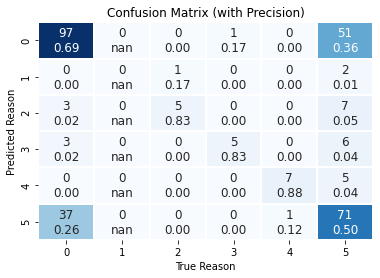

time: 309 ms (started: 2021-03-20 22:44:56 +00:00)


In [ ]:
# Plot confusion matrix
from sklearn.metrics import plot_confusion_matrix

mat = confusion_matrix(y_test, y_pred_test)
# Calculate each label counts
group_counts = ["{0:0.0f}".format(value) for value in mat.flatten()]
# Calculate each label precision
group_precision = ['{0:.2f}'.format(value) for value in (mat/mat.astype(np.float).sum(axis=0)).flatten()]
labels = [f'{v2}\n{v3}' for v2, v3 in zip(group_counts, group_precision)]
labels = np.asarray(labels).reshape(6,6)
ax = sns.heatmap(mat, annot=labels, linewidths=1, fmt='', annot_kws={"fontsize":12}, cmap='Blues', cbar=False)
ax.set(xlabel='True Reason', ylabel='Predicted Reason', title='Confusion Matrix (with Precision)')

### Bonus Deep Learning Model

#### Multilayer Perceptron Classifier (MLP)

In [ ]:
from sklearn.neural_network import MLPClassifier

mlp = MLPClassifier()

# Prepare param_grid
param_grid = {'activation': ['tanh', 'relu', 'logistic'],
              'alpha': [0.0001, 0.001, 0.05, 0.5, 1],
              'solver': ['sgd', 'adam'],
              'learning_rate': ['adaptive']}

# 5-fold Grid Search CV
mlp_cv = GridSearchCV(estimator = mlp, param_grid = param_grid, cv = 5, scoring = 'f1_weighted')
mlp_cv.fit(X_train, y_train)
print('Best hyperparameters:', mlp_cv.best_params_)
print('Best weighted F1 score:', mlp_cv.best_score_)

Best hyperparameters: {'activation': 'relu', 'alpha': 0.0001, 'learning_rate': 'adaptive', 'solver': 'adam'}
Best weighted F1 score: 0.5871839751007693
time: 8min 20s (started: 2021-03-20 22:46:58 +00:00)


In [ ]:
# Multilayer Perceptron model fitting and predictions
mlp2 = MLPClassifier(activation='relu',
                     alpha=0.0001,
                     solver='adam',
                     learning_rate='adaptive').fit(X_train, y_train)
y_pred_train = mlp2.predict(X_train)
y_pred_test = mlp2.predict(X_test)

# Print results
print('classifier_name: Multilayer Perceptron Classifier', '\n',
      'train accuracy:', round(accuracy_score(y_train, y_pred_train) * 100, 2), '%', '\n',
      'test accuracy:', round(accuracy_score(y_test, y_pred_test) * 100, 2), '%', '\n',
      'F1 score:', round(f1_score(y_test, y_pred_test, average='weighted'), 2))

# Print classification report
print(classification_report(y_test, y_pred_test, target_names=target_reason))

classifier_name: Multilayer Perceptron Classifier 
 train accuracy: 100.0 % 
 test accuracy: 59.27 % 
 F1 score: 0.59
                         precision    recall  f1-score   support

              Political       0.67      0.64      0.65       149
             Healthcare       0.00      0.00      0.00         3
                Economy       0.67      0.27      0.38        15
Women Rights and Racism       1.00      0.21      0.35        14
        Climate Problem       1.00      0.50      0.67        12
                 Others       0.49      0.65      0.56       109

               accuracy                           0.59       302
              macro avg       0.64      0.38      0.44       302
           weighted avg       0.63      0.59      0.59       302

time: 4.23 s (started: 2021-03-20 22:56:59 +00:00)


[Text(33.0, 0.5, 'Predicted Reason'),
 Text(0.5, 15.0, 'True Reason'),
 Text(0.5, 1.0, 'Confusion Matrix (with Precision)')]

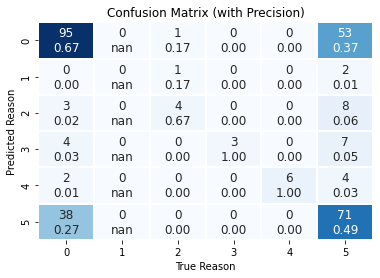

time: 392 ms (started: 2021-03-20 23:03:07 +00:00)


In [ ]:
# Plot confusion matrix
from sklearn.metrics import plot_confusion_matrix

mat = confusion_matrix(y_test, y_pred_test)
# Calculate each label counts
group_counts = ["{0:0.0f}".format(value) for value in mat.flatten()]
# Calculate each label precision
group_precision = ['{0:.2f}'.format(value) for value in (mat/mat.astype(np.float).sum(axis=0)).flatten()]
labels = [f'{v2}\n{v3}' for v2, v3 in zip(group_counts, group_precision)]
labels = np.asarray(labels).reshape(6,6)
ax = sns.heatmap(mat, annot=labels, linewidths=1, fmt='', annot_kws={"fontsize":12}, cmap='Blues', cbar=False)
ax.set(xlabel='True Reason', ylabel='Predicted Reason', title='Confusion Matrix (with Precision)')

The performance from the MLP classifier indicates that it overfits the training data while producing a relatively low test accuracy (59.27%). The test accuracy of the Logistic Regression Classifier still remains the highest at 62.91%. With the help of stratified train_test_split and balanced class weights, the multiclass Logistic Regression classifier outperforms the other three models and overfits less.

## Results Discussion

### First Model Discussion

From the EDA section, we took a first glance at the Canadian elections data. Out of the three parties, 20.91% of tweets are associated with Liberal, 18% of tweets are associated with Conservative, and only 4.55% are associated with NDP.

However, the party affiliation of around 56.54% of tweets could not be determined due to the following reasons:
- The keyword lists might not be comprehensive enough and might have missed some important keywords;
- The procedure of simply counting the number of particular keywords in a tweet might not be sufficient for determining party affiliation;
- Some tweets might be mutual such that keywords from multiple parties can appear in these tweets;
- Some tweets could have implied meaning and party affiliation that might not be detectable without the original context.

Looking at this result alone, the Liberal party seems to have more gotten attention from the voting population.

In the first half of this project, we use the sentiment analysis data along with different encoding methods (such as WF and TF-IDF) to construct and train 14 models. The best model that we decided to use for further hyperparameter tuning is the Logistic Regression model. After tuning, the LR model with bag-of-words encoding has a high accuracy of 94.37% with excellent precision and recall scores.

However, as we can see from the 'Visualizing Election Sentiment Prediction Results' section, simply implementing the best model (Logistic Regression) generated by the sentiment analysis section to the Canadian elections data did not yield great results. The model produced predictions with an accuracy of only 56.92%, with a recall of 0.26 and a precision of 0.78.

This change in performance could be due to the fact that the model was trained on general sentiment tweets data, which does not contain a lot of information about political opinions. Using such a model to test on the elections data would make it a bit difficult to capture most of the information within the data that is associated with political parties.

In [ ]:
# Party prediction results
party_dict

,party_name,true_positive,predicted_positive,true_negative,predicted_negative
0,Liberal,241,92,205,354
1,Conservative,116,45,268,339
2,NDP,65,21,32,76


time: 19.5 ms (started: 2021-03-21 20:57:56 +00:00)


Results generated from the LR model is displayed above. Out of the 2133 tweets in the Canadian elections data, the Liberal and the Conservative parties get the majority of attention from the public. Most of the population is more inclined to talk about the Liberal and Conservative parties.

From the confusion matrices generated for the three Canadian parties, we have the following observations:
- Accuracies for the political parties are: Liberal 58.52%, Conservative 72.14%, NDP 46.39%.
- The number of false positives are low, which means that the model does a relatively good job of identifying true positives. This also indicates that the model is more likely to predict negative labels, which could be the effect of training using the sentiment analysis data.
- Recall (TP/(TP+FN)) scores are low, which indicates that most of the positive labels have not been predicted by the model in this case.
- However, the model produces relatively acceptable precision scores (around 0.6 to 0.8), meaning that most of the predicted 'positive sentiment' labels are correct when compared to the true labels.

As a result, it is safe to say that using sentiment analysis based on tweets can be somewhat useful for political parties during election campaign. They can use this metric to assess or approximate the positive attitude of the voting population towards the parties during election.

### Second Model Discussion

In the last several sections, we construct models to predict the negative reasons within the Canadian elections data. After hyperparameter tuning of four models, the test accuracy of the Logistic Regression Classifier remains the highest at 62.91%.

With the help of stratified train_test_split and balanced class weights, the multiclass Logistic Regression classifier outperforms the other three models and overfits less compared to Naive bayes, Linear SVC, and Multilayer perceptron.

Multiclass LR model results:
- train accuracy: 83.38% (overfits)
- test accuracy: 62.91%
- weighted F1 score: 0.63

However, even with all these precautions implemented when tuning the model, the resulting performance is still far from ideal. We will explore this issue below.

In [ ]:
# Original counts for the 10 negative reasons
negative_df.negative_reason.value_counts()

Others                                 364
Scandal                                270
Tell lies                              198
Economy                                 51
Women Reproductive right and Racism     45
Climate Problem                         41
Separation                              16
Privilege                               12
Healthcare                               5
Healthcare and Marijuana                 4
Name: negative_reason, dtype: int64

time: 9.81 ms (started: 2021-03-20 22:23:54 +00:00)


Looking at the original counts for each negative reason, 7 of the 10 negative reasons have a very small number of samples within the elections data. After combining into 6 types of reason, over half of them still has very few samples. This is especially true with the 'Healthcare' reason, which has only 9 samples.

From the classification reports generated by each model, we can see that the target reasons with less supports tend to have much lower recall and F1 scores, especially for 'Healthcare', which only has 3 supports. This means that there are only 3 samples in the test set with the 'Healthcare' reason as label.

### Improvement Suggestions

For the first model, there are several ways to potentially improve its performance:
- Create more comprehensive lists of keywords when determining the party affiliation of each tweet;
- Instead of counting the occurrences of keywords in a tweet then use the max counts to determine party affiliation, we could also take into consideration the sentiment of the tweet;
- Include more features when using vectorizers (increase from 1200 to more);
- Further improve the hyperparameter tuning process.

For the second model, the following methods could potentially improve its performance:
- Change the reason encoding method to create more balanced target labels (however, this could lead to the loss of original meaning);
- Use resampling methods to upsample the classes with less frequencies (such as SMOTE or other methods);
- Increase the size of the elections data (obtain more data);
- For some of the models, such as LinearSVC, we could use an additional wrapper (CalibratedClassifierCV, OneVsRestClassifier, or OneVsOneClassifier) to further tune the probability of the model predictions;
- Include more features when using vectorizers (increase from 1200 to more);
- Try different models and tuning procedures to obtain better results.